In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import torch
import tqdm
import arviz as az

sys.path.append(os.path.dirname(os.getcwd())) 
from source.model_output import SEIRModelOutput, SEIRParams
from source.SEIR_network import SEIRNetworkModel
from source.autoencoder import AESurrogateModel
from source.forecast import SEIRForecaster
import source.plots as plots

from sklearn.metrics import r2_score

In [2]:
ae_model = AESurrogateModel(population=10**5)

In [ ]:

ae_model.simulate(0.5, 0.5)

array([ 3.32029343e-01,  1.04944855e+02,  2.22309158e+02,  2.56883301e+02,
        2.74819336e+02,  2.74410583e+02,  2.69670746e+02,  2.74968872e+02,
        2.80728668e+02,  2.71322693e+02,  2.82261505e+02,  2.98479523e+02,
        2.91635559e+02,  3.13074524e+02,  3.17771667e+02,  3.37615784e+02,
        3.36100525e+02,  3.48935242e+02,  3.60425232e+02,  3.63572632e+02,
        3.70977692e+02,  3.67045105e+02,  3.82676117e+02,  3.79026978e+02,
        3.76155792e+02,  3.76604248e+02,  3.83801880e+02,  3.83769012e+02,
        3.81164032e+02,  3.78115723e+02,  3.80003479e+02,  3.79389160e+02,
        3.72495178e+02,  3.72425293e+02,  3.69320740e+02,  3.55544281e+02,
        3.51256714e+02,  3.42296082e+02,  3.33037079e+02,  3.26607147e+02,
        3.23357178e+02,  3.16944000e+02,  3.03760529e+02,  2.94879517e+02,
        2.88315155e+02,  2.81342834e+02,  2.68936066e+02,  2.67805298e+02,
        2.52208130e+02,  2.48897552e+02,  2.40014908e+02,  2.32561157e+02,
        2.19488922e+02,  

In [3]:
beta = 0.5 # transmission rate
gamma = 0.3 # latent period rate
delta = 0.2 # recovery rate
init_inf_frac = 1e-4 # fraction of initially infected

alpha = 0.95
beta = 0.1

initial_params = SEIRParams(0.5, 0.5, gamma, delta, init_inf_frac, tmax=150)
observed_incidence = np.loadtxt('../data/incidence_synthetic_curve.csv')
simulation_incidence = ae_model.simulate(alpha, beta, gamma, delta, init_inf_frac)
forecaster = SEIRForecaster(initial_params=initial_params)

In [4]:
idata = forecaster.calibrate(ae_model, observed_incidence)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/Users/andrey/hybrid_surrogate/.env/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [5]:
true_alpha = 0.95
true_beta = 0.1
# Пример использования:
# fig = plots.create_plots_grid(idata, observed_incidence, true_params_dict={'alpha': true_alpha, 'beta': true_beta})
# fig.savefig(r'../figures/ae_ba_network_retrospective_calibration_{}.pdf'.format(index), 
#             bbox_inches='tight')
# fig.savefig(r'../figures/ae_ba_network_retrospective_calibration.png', 
            # dpi = 600, bbox_inches='tight')

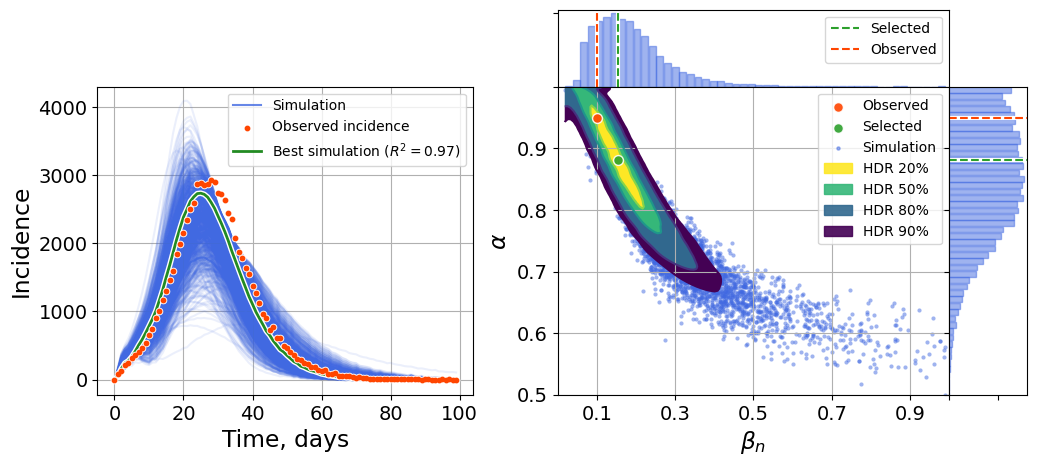

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib as mpl
import matplotlib.patches as mpatches


fig = plots.plot_calib(idata, observed_incidence, 
                 true_params_dict={'alpha': true_alpha, 'beta': true_beta})
fig.savefig('../figures/ae_ba_network_hdr_abc_epsilon=2000.pdf', bbox_inches='tight')
fig.savefig('../figures/ae_ba_network_hdr_abc_epsilon=2000.png', bbox_inches='tight', dpi=600)